Task: Ship position prediction based on past observation

Dataset: I have chosen dataset of April 2016 - Zone 14 ('AIS_2016_04_Zone14.csv') from the https://marinecadastre.gov/ais/ 

---



import all necessary library and packages

In [0]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential,load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.layers.core import Dense, Dropout, Lambda
from keras.optimizers import rmsprop,Adam
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.regularizers import l2,l1,l1_l2
from keras import initializers
import matplotlib.pyplot as plt
import time
seed = 1234

Specify dataset file and store it in variable named data

---



In [0]:
from google.colab import files
uploaded = files.upload()

Saving AIS_2016_04_Zone14.csv to AIS_2016_04_Zone14.csv


In [0]:
data = pd.read_csv('AIS_2016_04_Zone14.csv')

In [0]:
data.shape

(3729293, 16)

This file contain data for many ships in the month of April,2016. out of this I have chosen ship named 'MISS JULIE' for this task, as there were more entries for this ship in the dataset.

In [0]:
#  select one ship named 'Miss Julie'
missJulie = data.loc[data['VesselName'] == 'MISS JULIE']

Here we are using data for only one month therefore,  year and month part in the pandas datetime object  is not useful. So first extract day,hour,minute,second data from the BaseDateTime column. 

Instead of using different variables representing hour,minute and second information, lets convert it into only one variable named totalTime. Also we have many other columns, which has constant value for all the entries. this will not add any information for the prediction task. so lets delete all those columns.

In [0]:
#seperate date, hour,minute,second data
missJulie['day'] = pd.DatetimeIndex(missJulie['BaseDateTime']).day
missJulie['hour'] = pd.DatetimeIndex(missJulie['BaseDateTime']).hour
missJulie['minute'] = pd.DatetimeIndex(missJulie['BaseDateTime']).minute
missJulie['second'] = pd.DatetimeIndex(missJulie['BaseDateTime']).second
missJulie['totalTime'] = missJulie['hour'].multiply(3600) + missJulie['minute'].multiply(60) + missJulie['second']

# delete columns with constant values
del missJulie['MMSI']
del missJulie['BaseDateTime']
del missJulie['Heading']
del missJulie['VesselName']
del missJulie['IMO']
del missJulie['CallSign']
del missJulie['VesselType']
del missJulie['Length']
del missJulie['Width']
del missJulie['Draft']
del missJulie['Cargo']
del missJulie['Status']
del missJulie['hour']
del missJulie['minute']
del missJulie['second']




In [0]:
missJulie.shape

(29592, 6)

So. now we have dataset with six columns. First two are LAT and LON which represents position. Other four are SOG,COG, day and totalTime. We will use LAT and LON as our labels for the training and rest four as input features for the model

In [0]:
x= missJulie.iloc[:,2:] # input features
y= missJulie.iloc[:,0:2] # labels


In [0]:
x.shape

(29592, 4)

In [0]:
y.shape

(29592, 2)

In [0]:
missJulie.head()

,LAT,LON,SOG,COG,day,totalTime
1465,27.81530,-96.33104,8.1,-133.0,1,354
1469,27.81544,-96.33971,7.9,-138.3,1,564
1472,27.81591,-96.35719,7.9,-136.8,1,984
1474,27.81712,-96.38027,8.7,-142.4,1,1533
1478,27.81518,-96.31696,7.3,-132.2,1,5


In [0]:
x.head()

,SOG,COG,day,totalTime
1465,8.1,-133.0,1,354
1469,7.9,-138.3,1,564
1472,7.9,-136.8,1,984
1474,8.7,-142.4,1,1533
1478,7.3,-132.2,1,5


In [0]:
y.head()

,LAT,LON
1465,27.81530,-96.33104
1469,27.81544,-96.33971
1472,27.81591,-96.35719
1474,27.81712,-96.38027
1478,27.81518,-96.31696


Split dataset in training and test. We will seperate 20% of the total data and use it for testing the performance of the model.

In [0]:
x_train, x_test, y_train, y_test = train_test_split (x,y,test_size = 0.2, random_state = seed)

As, all the features have values in diferent ranges, we will use MinMax Sxaler to scale all features and label to have values in the range of (-1,1)

In [0]:
scaler_x=preprocessing.MinMaxScaler(feature_range =(-1 , 1))

x_train_scalled=scaler_x.fit_transform(x_train)
x_test_scalled=scaler_x.transform(x_test)    

scaler_y=preprocessing.MinMaxScaler(feature_range =(-1 , 1))
y_train_scalled=scaler_y.fit_transform(y_train)
y_test_scalled=scaler_y.transform(y_test)

Lets define a Neural network model. We will use fully connected layers to build a network. 

In [0]:
# define model
model = Sequential()
model.add(Dense(4, input_shape=(4,),kernel_regularizer='l1_l2',activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(2,activation='linear'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_42 (Dense)             (None, 128)               640       
_________________________________________________________________
dense_43 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_44 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 258       
Total params: 132,630
Trainable params: 132,630
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile model
# adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)
model.compile(optimizer='adam', loss='mse')

define callbacks to prevent model from overfitting 
Earlystopping, reduce learning rate on plateau and check point to save the model

In [0]:
#%% callbacks
weight_name = 'model.h5'
checkpoint = ModelCheckpoint(weight_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='min')
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=0, mode='auto', cooldown=0,
                       min_lr=1e-6)
callbacks_list = [checkpoint, lr, early]

In [0]:
# train model
samples = len(x_train)
startTime = time.time()
history = model.fit(x_train_scalled, y_train_scalled,
                    epochs=100,
                    shuffle = False,
                    batch_size = 32,
                    verbose=1,
                    validation_split = 0.1,
                    callbacks = callbacks_list)
endTime = time.time()
timeToTrain = endTime - startTime

Train on 21305 samples, validate on 2368 samples
Epoch 1/100
21305/21305 [==============================] - 4s 170us/step - loss: 0.3302 - val_loss: 0.2755

Epoch 00001: val_loss improved from inf to 0.27551, saving model to model.h5
Epoch 2/100
21305/21305 [==============================] - 3s 117us/step - loss: 0.2452 - val_loss: 0.2116

Epoch 00002: val_loss improved from 0.27551 to 0.21157, saving model to model.h5
Epoch 3/100
21305/21305 [==============================] - 3s 120us/step - loss: 0.1908 - val_loss: 0.1745

Epoch 00003: val_loss improved from 0.21157 to 0.17445, saving model to model.h5
Epoch 4/100
21305/21305 [==============================] - 3s 124us/step - loss: 0.1516 - val_loss: 0.1417

Epoch 00004: val_loss improved from 0.17445 to 0.14165, saving model to model.h5
Epoch 5/100
21305/21305 [==============================] - 3s 121us/step - loss: 0.1275 - val_loss: 0.1221

Epoch 00005: val_loss improved from 0.14165 to 0.12213, saving model to model.h5
Epoch 6/10

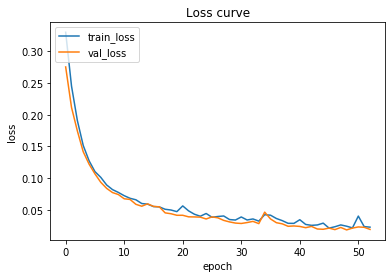

In [0]:
# plot loss curves
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc='upper left')

Now predict the position for the test dataset


In [0]:
y_predict = model.predict(x_test_scalled)

as the labels are also scaled to have vlues between (-1,1), we need to inverse scale the predition to get the right data

In [0]:
y_predict_inv_scalled = scaler_y.inverse_transform(y_predict)

Y_predict_inv_scalled has 2 columns one representing LAT and another one representing LON prediction data. Lets plot a graph between original LAT and predicited LAT data

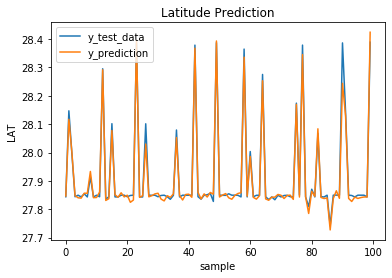

In [0]:
plt.figure(1)
plt.plot(np.array(y_test['LAT'])[1400:1500,])
plt.plot(y_predict_inv_scalled[1400:1500,0]) #y_predict_inv_scalled
plt.title('Latitude Prediction')
plt.ylabel('LAT')
plt.xlabel('sample')
plt.legend(['y_test_data','y_prediction'], loc='upper left')

plot a graph between original LON and predicited LON data

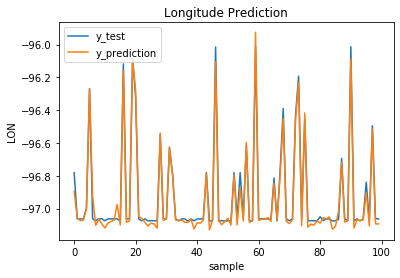

In [0]:
plt.figure(1)
plt.plot(np.array(y_test['LON'])[4000:4100,])
plt.plot(y_predict_inv_scalled[4000:4100,1])
plt.title('Longitude Prediction')
plt.ylabel('LON')
plt.xlabel('sample')
plt.legend(['y_test','y_prediction'], loc='upper left')

Measure the root mean square between original test position data and predicted poistion data

In [0]:
# performance measure - calculate mean squared error between predicted data and original data
rmse_LAT = sqrt(mean_squared_error(np.array(y_test['LAT'])[:,], y_predict_inv_scalled[:,0]))
rmse_LON = sqrt(mean_squared_error(np.array(y_test['LON'])[:,], y_predict_inv_scalled[:,1]))
print('RMSE for LAT is: %.9f' % rmse_LAT)
print('RMSE for LON is: %.9f' % rmse_LON)

RMSE for LAT is: 0.020246409
RMSE for LON is: 0.062277771


Performance of the model can be further improved by changing different parameters of the model like number and types of layers, optimization algorithm, number of epochs, batch_size, etc.



---



**To predict position for any new data:**
new data must be in this form: (SOG, COG, day, totalTime) where totalTime = hour x 3600 + minutes x 60 + seconds

`newX = np.array([SOG, COG,	day, totalTime]) `

scale 'newX' with the same scaler which was used for scalin the training data (i.e. scalerX) 

```
newX = scaler_x.transform(newX)
newPos = model.predict(newX)
```


inverse scale the prediction

`newPos = scaler_y.inverse_transform(newPos)`     #newPos is in the form : (LAT,LON)